In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
# preprocessing：前処理  StandardScaler：標準化
from sklearn.preprocessing import StandardScaler
# データを訓練データとテストデータに分割する
from sklearn.model_selection import train_test_split
# クラス分類をする
from sklearn.linear_model import SGDClassifier
# 評価指標
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, f1_score
# 平均絶対誤差
from sklearn.metrics import mean_absolute_error
# 日時を扱う
import datetime as dt
# ロジスティック回帰
from sklearn.linear_model import LogisticRegression
# AUCとROC
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
# ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_decision_regions
# 決定木
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import datasets
from IPython.display import Image
import pydotplus

Duplicate key in file PosixPath('/Users/akira/opt/anaconda3/envs/practice/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 250 ('font.family:  sans-serif')


In [2]:
# データの読み込み
kickstar = pd.read_csv('./data/ks-projects-201801 2.csv')

# いらないカラムの削除
kickstar = kickstar.drop(['ID', 'name', 'category', 'usd_pledged_real', 'usd_goal_real'], axis=1)

# 開始日と締め切りの差を期間として、periodという新しいカラムを作成
kickstar['deadline'] = pd.to_datetime(kickstar['deadline'])
kickstar['launched'] = pd.to_datetime(kickstar['launched'])
kickstar['period'] = (kickstar['deadline'] - kickstar['launched']).dt.days
kickstar =kickstar.drop(['deadline', 'launched'], axis=1)

# ダミー変数の作成
kickstar = pd.get_dummies(kickstar,columns=['main_category', 'currency', 'country'])

# 欠損行削除
kickstar = kickstar.dropna()

# 目的変数を成功か失敗の２つに絞る
kickstar = kickstar[(kickstar['state'] == 'successful') | (kickstar['state'] == 'failed')]

# 説明変数と目的変数を用意
y = kickstar['state'].values #'state' の値をyに代入する
X = kickstar.drop('state', axis=1).values #'state'以外の変数をXに代入する

# trainとtestに分割
test_size = 0.2 #テストデータの割合を決める
#訓練データとテストデータに分割し、それぞれ変数に代入する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

In [3]:
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (265172, 57)
X_test: (66293, 57)
y_train: (265172,)
y_test: (66293,)


In [4]:
# 標準化
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train) #訓練データの標準化
X_test_std = stdsc.transform(X_test) #テストデータの標準化

# 決定木

* 不純度(ジニ係数, エントロピー)を指標として、特徴量の領域を分割。
ジニ係数：分割領域に正解ラベルが混在した状態だと0.5に近く、正解ラベルが分割された状態だと0に近くなる。  
(それぞれの領域において全てが同じ種類になっていること)


$$I_G(t) = 1 - \sum_{i=1}^{c} p(i|t)^2$$

不純度が最小になるように領域を分割する。  

$$🔴❌🔴❌🔴❌ → 1 - \biggl(\Bigl(\frac{3}{6}\Bigl)^2 + \Bigl(\frac{3}{6}\Bigl)^2\biggl) \ = \ 0.5$$

$$🔴❌🔴|❌🔴❌ → \frac{3}{6} \times 1 - \biggl(\Bigl(\frac{2}{3}\Bigl)^2 + \ \Bigl(\frac{1}{3}\Bigl)^2\biggl)\ +\ \frac{3}{6} \ \times\ 1 - \biggl(\Bigl(\frac{1}{3}\Bigl)^2 + \ \Bigl(\frac{2}{3}\Bigl)^2\biggl) \ = \ 0.44$$

$$🔴🔴|❌❌🔴❌ → \frac{2}{6} \times 1 - \biggl(\Bigl(\frac{2}{2}\Bigl)^2 + \ \Bigl(\frac{0}{2}\Bigl)^2\biggl)\ +\ \frac{4}{6} \ \times\ 1 - \biggl(\Bigl(\frac{1}{4}\Bigl)^2 + \ \Bigl(\frac{3}{4}\Bigl)^2\biggl) \ = \ 0.25$$

# 決定木でモデル作成から可視化まで

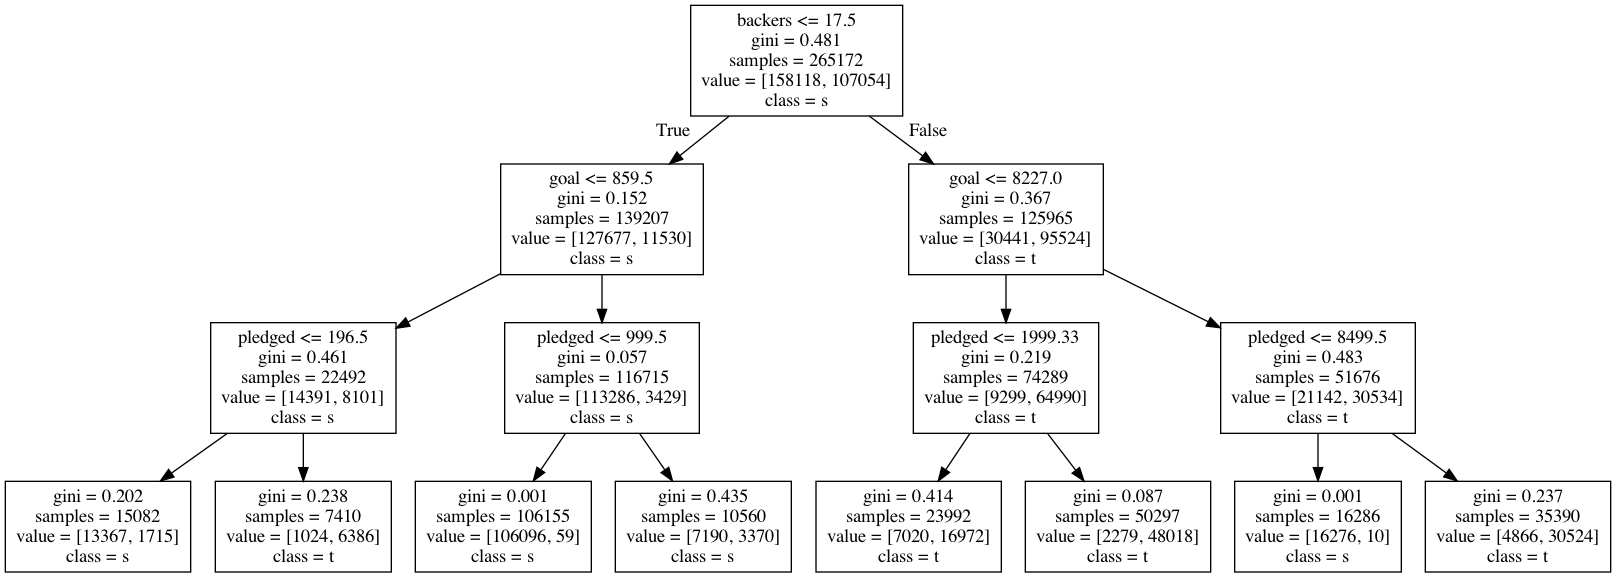

In [5]:

# モデル作成
model = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)

# 学習
model.fit(X_train, y_train)

columns_name = kickstar.drop('state', axis=1).columns.values

# DOTフォーマットでデータを作成
dot_data = export_graphviz(model, out_file=None, feature_names=columns_name, class_names='state')

graph = pydotplus.graph_from_dot_data(dot_data)
# 可視化
Image(graph.create_png())

# ランダムフォレスト

* 特徴量空間（説明変数となるデータがある空間）が線形分離可能な場合のみ高い性能を発揮します。

* 異なるランダムな特徴量で決定きを作成して多数決をとる。

* 特徴量の重要度をランキングできる。

アンサンブル学習のバギングをベースに、少しずつ異なる決定木をたくさん集めたもの。
決定木単体の過学習しやすい欠点に対応。(決定木を深くしすぎると、数式による前提条件がないため、データに敏感で過学習が起きる。)
それぞれ異なった方向に過学習している決定木をたくさん作れば、その結果の平均を取ることで過学習の度合いを減らすことができる。　　

## 引数

### bootstrap
復元抽出の有無を指定。

### n_estimators
いくつの決定木を用意するかを設定。  
大きいほど良いが、時間とメモリをくう。

### max_features
各グループの特徴量の個数。 

### criterion
ジニ係数, エントロピーなどの不純度の指標を指定。

### max_depth
決定木の深さを指定。noneの場合は不純度が０(完全に分類できるまで枝が増えていくため、過学習を起こしている可能性がある)。

### random_state
乱数のシードを固定。

# アンサンブル学習
* 複数の機械学習モデルを組み合わせることで、より強力なモデルを構築するやり方。
* 複数の学習器の多数決をとる。

## バギング
ブートストラップ(元データから一部のデータを復元抽出というやり方でサンプリング)というやり方で複数のモデルを並列的に学習。  
復元抽出:重複を許す抽出方法。


# モデル作成

In [6]:
model = RandomForestClassifier(bootstrap=True, n_estimators=10, criterion='gini', max_depth=None, random_state=1)
model.fit(X_train_std, y_train)
print("score=", model.score(X_test_std, y_test))

score= 0.992502979198407


In [7]:
# 予測
y_pred = model.predict(X_test_std)

# 正解率
ac_score = accuracy_score(y_test, y_pred)
print('正解率： {}'.format(ac_score))

正解率： 0.992502979198407


([<matplotlib.axis.XTick at 0x7fe31ea55e90>,
 [Text(0, 0, 'pledged'),
  Text(1, 0, 'backers'),
  Text(2, 0, 'goal'),
  Text(3, 0, 'usd pledged'),
  Text(4, 0, 'period'),
  Text(5, 0, 'main_category_Technology'),
  Text(6, 0, 'main_category_Music'),
  Text(7, 0, 'main_category_Design'),
  Text(8, 0, 'main_category_Theater'),
  Text(9, 0, 'main_category_Food'),
  Text(10, 0, 'main_category_Games'),
  Text(11, 0, 'main_category_Art'),
  Text(12, 0, 'country_GB'),
  Text(13, 0, 'main_category_Film & Video'),
  Text(14, 0, 'main_category_Dance'),
  Text(15, 0, 'country_US'),
  Text(16, 0, 'main_category_Publishing'),
  Text(17, 0, 'main_category_Fashion'),
  Text(18, 0, 'currency_USD'),
  Text(19, 0, 'main_category_Crafts'),
  Text(20, 0, 'currency_EUR'),
  Text(21, 0, 'currency_GBP'),
  Text(22, 0, 'main_category_Comics'),
  Text(23, 0, 'main_category_Photography'),
  Text(24, 0, 'country_CA'),
  Text(25, 0, 'currency_SEK'),
  Text(26, 0, 'country_AU'),
  Text(27, 0, 'country_DE'),
  Text(

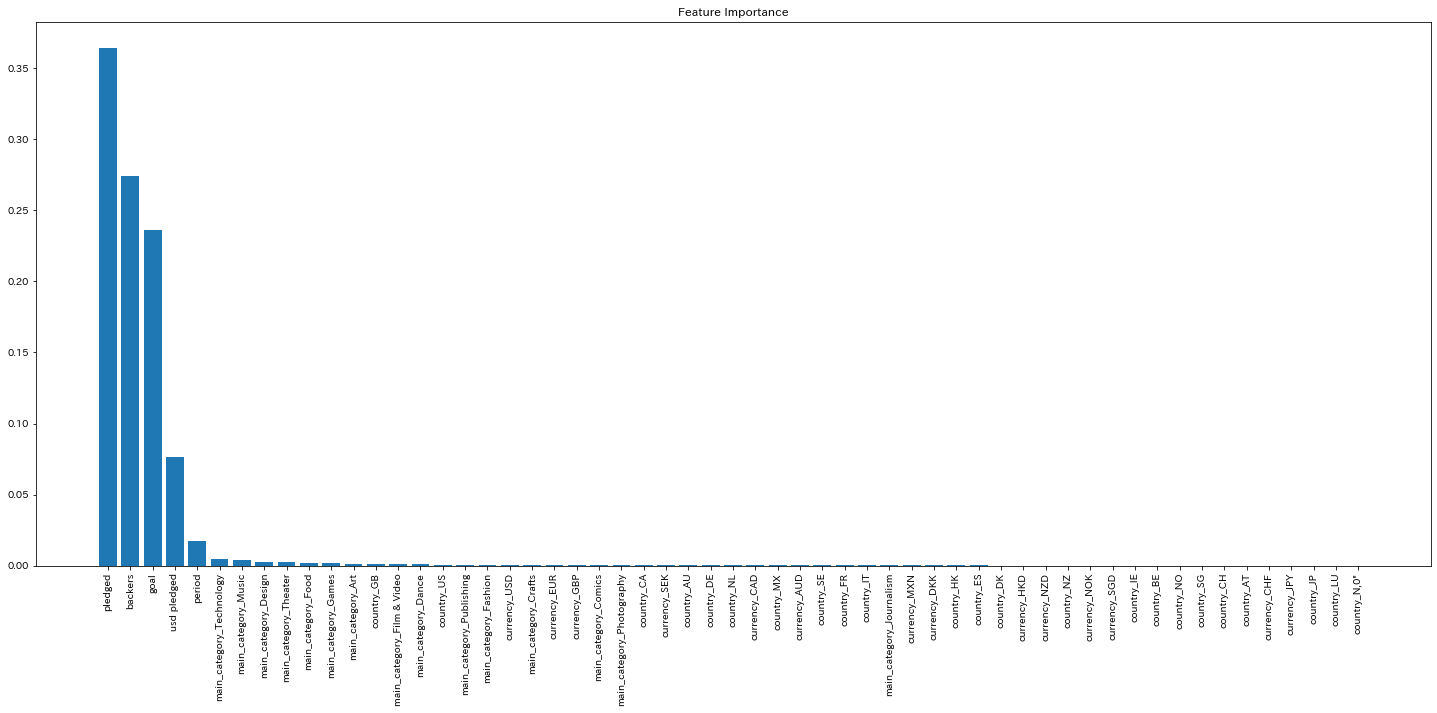

In [8]:
# 特徴量重要度を計算
importances = model.feature_importances_

# 降順にソート
indices = np.argsort(importances)[::-1]

# 特徴量の名前をソートした順に並び替え
columns_name = kickstar.drop('state', axis=1).columns.values
names = [columns_name[i] for i in indices]

# 可視化
plt.figure(figsize=(25, 10))
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)

# 考察
特徴量重要度の可視化から、countryとcurrencyとmain_categoryを抜いて分析してみる。

score= 0.9985820524037229
正解率： 0.9985820524037229


([<matplotlib.axis.XTick at 0x7fe2fac1e110>,
 [Text(0, 0, 'backers'),
  Text(1, 0, 'pledged'),
  Text(2, 0, 'goal'),
  Text(3, 0, 'usd pledged'),
  Text(4, 0, 'period')])

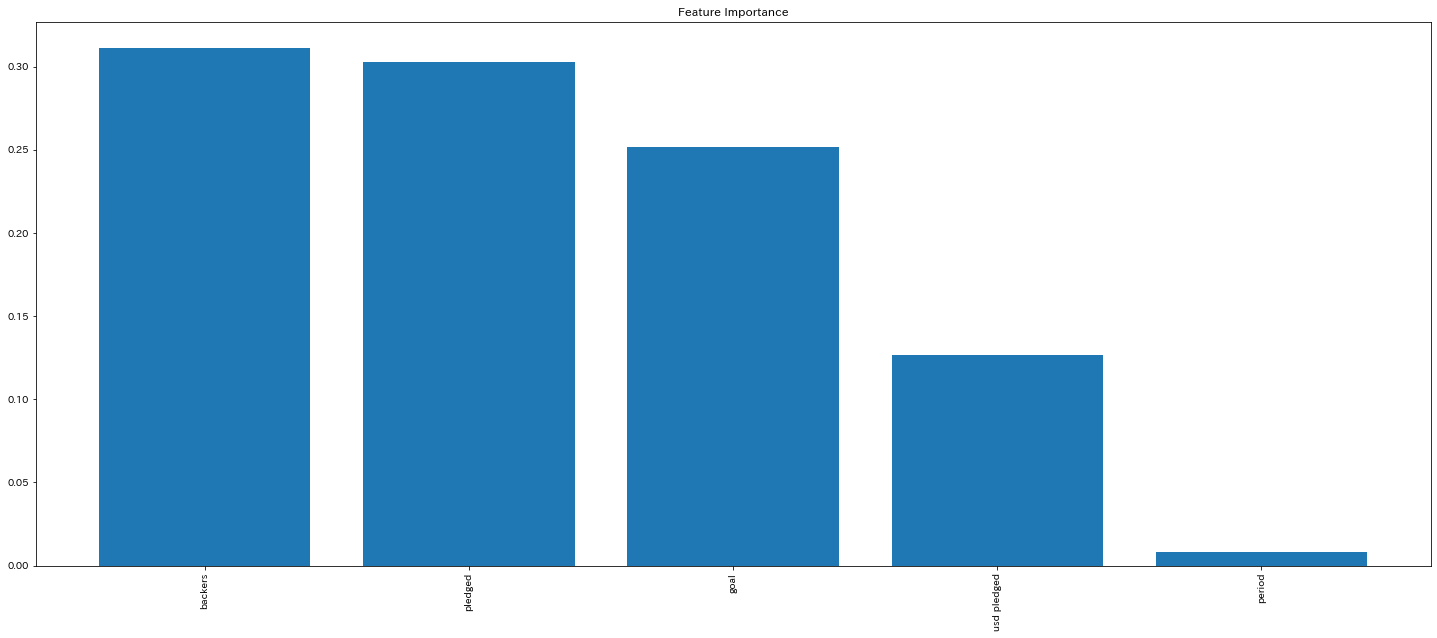

In [9]:
# データの読み込み
kickstar = pd.read_csv('./data/ks-projects-201801 2.csv')

# いらないカラムの削除
kickstar = kickstar.drop(['ID', 'name', 'category', 'usd_pledged_real', 'usd_goal_real', 'currency', 'country', 'main_category'], axis=1)

# 開始日と締め切りの差を期間として、periodという新しいカラムを作成
kickstar['deadline'] = pd.to_datetime(kickstar['deadline'])
kickstar['launched'] = pd.to_datetime(kickstar['launched'])
kickstar['period'] = (kickstar['deadline'] - kickstar['launched']).dt.days
kickstar =kickstar.drop(['deadline', 'launched'], axis=1)

# 欠損行削除
kickstar = kickstar.dropna()

# 目的変数を成功か失敗の２つに絞る
kickstar = kickstar[(kickstar['state'] == 'successful') | (kickstar['state'] == 'failed')]

# 説明変数と目的変数を用意
y = kickstar['state'].values #'state' の値をyに代入する
X = kickstar.drop('state', axis=1).values #'state'以外の変数をXに代入する

# trainとtestに分割
test_size = 0.2 #テストデータの割合を決める
#訓練データとテストデータに分割し、それぞれ変数に代入する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

# 標準化
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train) #訓練データの標準化
X_test_std = stdsc.transform(X_test) #テストデータの標準化

model = RandomForestClassifier(bootstrap=True, n_estimators=10, criterion='gini', max_depth=None, random_state=1)
model.fit(X_train_std, y_train)
print("score=", model.score(X_test_std, y_test))

# 予測
y_pred = model.predict(X_test_std)

# 正解率
ac_score = accuracy_score(y_test, y_pred)
print('正解率： {}'.format(ac_score))

# 特徴量重要度を計算
importances = model.feature_importances_

# 降順にソート
indices = np.argsort(importances)[::-1]

# 特徴量の名前をソートした順に並び替え
columns_name = kickstar.drop('state', axis=1).columns.values
names = [columns_name[i] for i in indices]

# 可視化
plt.figure(figsize=(25, 10))
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)

# 再度考察
うまくできたが、精度が良すぎるため過学習を起こしている可能性がある...。